# Gradient-based Optimization of Hyperparameters in Linear Models

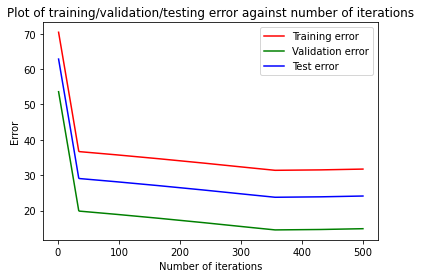

In [29]:
import numpy as np
from sklearn.datasets import load_boston
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# import the dataset from sklearn's inbuilt datasets
dataset = load_boston()
X = dataset.data
y = dataset.target 
description = dataset.DESCR
feature_names = dataset.feature_names

n = 13 # number of features
N = len(X) # number of datapoints
alpha = 0.01 # learning rate
iters = 500

# Shuffle the dataset (optional)
# X,y = shuffle(X,y,random_state = 0)

# split the data into train, test and validation data
index1 = 456 
index2 = 481

X_train = X[:index1]
X_valid = X[index1:index2]
X_test = X[index2:]

y_train = y[:index1]
y_valid = y[index1:index2]
y_test = y[index2:]

# swapping validation and testing data
# tempx = X_valid
# tempy = y_valid
# X_valid = X_test
# y_valid = y_test
# X_test = tempx
# y_test = tempy

# compute b and outer product
outer_product = np.zeros((13,13))
b = np.zeros(13)
for i in range(len(X_train)):
    b -= X_train[i] * y_train[i]
    outer_product += np.outer(X_train[i], X_train[i])
    
# the chief bug was 1-based indexing used in research paper
def cholesky(H):
    n = len(H)
    L = np.zeros((n, n))
    for i in range(n):
        sumL = 0
        for k in range(i): # changed from range(i-1) to range(i)
            sumL += L[i][k] ** 2
        L[i][i] = math.sqrt(H[i][i] - sumL)
        for j in range(i+1, n):
            sumL = 0
            for k in range(i): # changed from range(i-1) to range(i)
                sumL += L[i][k] * L[j][k]
            L[j][i] = (H[i][j] - sumL)/L[i][i]
    return L

def compute_error(LAMBDA, w, X, y):
    error = 0
    for i in range(len(X)):
        error += ((np.dot(w, X[i]) - y[i]) ** 2)
    error /= len(X)
    for i in range(n):
        error += (LAMBDA[i] * w[i] * w[i])
    #print('computed error: ', error)
    return error
    
    

# Step 1: Initialise lambda with some value 

# LAMBDA = np.random.rand(13) # Random initialisation of lambda
LAMBDA = np.ones(n) # lambda initialised to vector of ones
iterations = 1

# Store the training, validation and testing error
train_err = []
valid_err = []
test_err = []

# Used for plotting the results
# iter_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
iter_list = range(1, iters + 1)

# Used for plotting lambda values
lambda_val = []
w_val = []
wx = []
for i in range(n):
    lambda_val.append([])
    w_val.append([])

while iterations <= 2001:
    # Step 2: H(lambda)
    A = np.zeros((13,13))
    np.fill_diagonal(A, LAMBDA)
    H = outer_product + A

    # Step 3: Find cholesky decomposition of H
    L = cholesky(H)

    # Step 4: Find optimal parameters w for fixed lambda by solving -b = Hw
    # First solve Lu = -b for u:
    u = np.zeros(n)
    for i in range(n):
        sumU = 0
        for k in range(i):
            sumU += L[i][k] * u[k]
        u[i] = (-b[i] - sumU) / L[i][i]

    w = np.zeros(n)
    # Now solve L^T w = u for w:
    for i in range(n-1, -1, -1):
        sumW = 0
        for k in range(i+1, n):
            sumW += L[k][i] * w[k]
        w[i] = (u[i] - sumW) / L[i][i]

    #if iterations == 1000 or iterations == 10000 or iterations == 1:
    if iterations in iter_list:
        #print('iter: ', iterations)
        
        # Uncomment the next 3 lines to print the weight vectors and lambda 
        #print('w: ', w)
        #print('lambda: ', LAMBDA)

        # Uncomment the next 3 lines to compute & plot the train, test and validation error 
        train_err.append(compute_error(LAMBDA, w, X_train, y_train))
        valid_err.append(compute_error(LAMBDA, w, X_valid, y_valid))
        test_err.append(compute_error(LAMBDA, w, X_test, y_test))
        
        # Uncomment the next 3 lines to compute & plot the weight vectors w and also the lambda
        for j in range(n):
            lambda_val[j].append(LAMBDA[j]) 
            w_val[j].append(w[j])

        # Uncomment the next 4 lines to print the LAMBDA values and the weight values at specific iterations
        #print('train error: ',compute_error(LAMBDA, w, X_train, y_train))
        #print('valid error: ', compute_error(LAMBDA, w, X_valid, y_valid))
        #print('test error: ', compute_error(LAMBDA, w, X_test, y_test))
        #print('\n')

    # Step 5: compute the gradient of validation error gradient (dE/dw) (old version)
#     dEdw = np.zeros(n)
#     for i in range(len(X)):
#         dEdw += X[i] * (np.dot(w, X[i]) - y[i])
#     dEdw = dEdw * (1 / len(X))

    # Step 5: compute the gradient of validation error gradient (dE/dw)
    dEdw = np.zeros(n)
    for i in range(len(X_valid)):
        dEdw += X_valid[i] * (np.dot(w, X_valid[i]) - y_valid[i])
    dEdw = dEdw * (1 / len(X_valid))

    
    # Step 6: back-propagation of gradients

    # First backpropagate through the solution of L^w = u
    dEdL = np.zeros((n, n))
    dEdu = np.zeros(n)
    for i in range(n):
        dEdu[i] = dEdw[i] / L[i][i]
        dEdL[i][i] = dEdL[i][i] - (dEdw[i] * w[i]) / L[i][i]
        for k in range(i+1, n):
            dEdw[k] = dEdw[k] - (dEdw[i] * L[k][i]) / L[i][i]
            dEdL[k][i] = dEdL[k][i] - (dEdw[i] * w[k]) / L[i][i]

    # Then backpropagate through the solution of Lu = -b
    dEdb = np.zeros(n)
    for i in range(n-1, -1, -1):
        dEdb[i] = -dEdu[i] / L[i][i]
        dEdL[i][i] = dEdL[i][i] - (dEdu[i] * u[i]) / L[i][i]
        for k in range(i):
            dEdu[k] = dEdu[k] - (dEdu[i] * L[i][k]) / L[i][i]
            dEdL[i][k] = dEdL[i][k] - (dEdu[i] * u[k]) / L[i][i]

    # Convert the gradients wrt L into gradients wrt H
    dEdH = np.zeros((n, n))
    for i in range(n-1, -1, -1):
        for j in range(n-1, i, -1):
            dEdL[i][i] = dEdL[i][i] - (dEdL[j][i] * L[j][i]) / L[i][i]
            dEdH[i][j] = dEdL[j][i] / L[i][i]
            for k in range(i):
                dEdL[i][k] = dEdL[i][k] - (dEdL[j][i] * L[j][k]) / L[i][i]
                dEdL[j][k] = dEdL[j][k] - (dEdL[j][i] * L[i][k]) / L[i][i]
        dEdH[i][i] = 0.5 * dEdL[i][i] * L[i][i]
        for k in range(i):
            dEdL[i][k] = dEdL[i][k] - (dEdL[i][i] * L[i][k]) / L[i][i]

    # We have computed gradients only for upper diagonal of H, so copy the gradients into lower diagonal as well
    for i in range(n):
        for j in range(i+1, n):
            dEdH[j][i] = dEdH[i][j]

    # Step 7: Compute dEdLambda
    dEdLambda = np.zeros(n)
    for k in range(n):
        dEdLambda[k] = dEdH[k][k]

    # Step 8: Do gradient descent on lambda
    LAMBDA = LAMBDA - dEdLambda * alpha
    for i in range(n):
        if LAMBDA[i] < 0:
            LAMBDA[i] = 0
    iterations += 1
    

# iter_list = ['1', '2', '5', '10', '20', '50', '100', '200', '500', '1000']

# for i in range(len(iter_list)):
#     iter_list[i] = str(iter_list[i])

# Uncomment the next block of code, to plot the train, validation and test errors on a single graph
plt.plot(iter_list, train_err, color = 'r', label = 'Training error')
plt.plot(iter_list, valid_err, color = 'g', label = 'Validation error')
plt.plot(iter_list, test_err, color = 'b', label = 'Test error')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.title('Plot of training/validation/testing error against number of iterations')
plt.legend()
plt.savefig('result.pdf')
plt.show()

# Uncomment the next block of code, to plot LAMBDA values against the number of iterations
# plt.figure(figsize=(10, 7))
# for j in range(n):
#     plt.plot(iter_list, lambda_val[j], label = 'lambda[' + str(j) + ']')
# plt.xlabel('Number of iterations')
# plt.ylabel('Lambda values')
# plt.title('Plot of lambda values against no. of iterations')
# plt.legend()
# plt.savefig('lambda new.pdf')
# plt.show()

# Uncomment the next block of code to plot the weight vectors
# plt.figure(figsize=(15, 10))
# for j in range(n):
#     plt.plot(iter_list, w_val[j], label = 'w[' + str(j) + ']')
# plt.xlabel('Number of iterations')
# plt.ylabel('w values')
# plt.title('Plot of w (actual parameter) values against no. of iterations')
# plt.legend()
# plt.savefig('w.pdf')
# plt.show()

# plt.figure(figsize=(15, 10))
# for j in range(n):
#     plt.plot(iter_list, wx[:,j], label = 'w[' + str(j) + ']')
# plt.xlabel('Number of iterations')
# plt.ylabel('w values')
# plt.title('Plot of w (actual parameter) values against no. of iterations')
# plt.legend()
# plt.savefig('w.pdf')
# plt.show()

### Features in the dataset

CRIM per capita crime rate by town <br>
ZN proportion of residential land zoned for lots over 25,000 sq.ft. <br>
INDUS proportion of non-retail business acres per town <br>
CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) <br>
NOX nitric oxides concentration (parts per 10 million) <br>
RM average number of rooms per dwelling <br>
AGE proportion of owner-occupied units built prior to 1940 <br>
DIS weighted distances to five Boston employment centres <br>
RAD index of accessibility to radial highways <br>
TAX full-value property-tax rate per 10,000usd <br>
PTRATIO pupil-teacher ratio by town <br>
B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town <br>
LSTAT % lower status of the population <br>